# Time evolution : SIS model

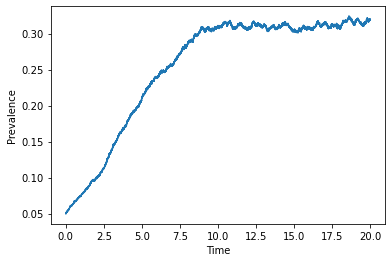

In [1]:
from spreading_CR import SpreadingProcess
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#create a random graph using networkx
seed = 42
N = 10000
p = 10**(-3)
G = nx.fast_gnp_random_graph(N,p, seed = seed)

#propagation parameters
transmission_rate = 0.15         
recovery_rate = 1              #rate at which infected nodes become recovered
waning_immunity_rate = np.inf  #rate at which recovered nodes become susceptible
infected_fraction = 0.05       #Initial infected fraction - at random

#initialize the propagation process
sp = SpreadingProcess(list(G.edges()), transmission_rate, recovery_rate, 
    waning_immunity_rate)
sp.initialize_random(infected_fraction, seed)

#simulate the process
t = 20
sp.evolve(t)

#get data vectors
Inode_number_vector = sp.get_Inode_number_vector()
time_vector = sp.get_time_vector()

#format 
prevalence_vector = [i/N for i in Inode_number_vector]

#draw the temporal sequence
plt.plot(time_vector, prevalence_vector)
plt.xlabel(r'Time')
plt.ylabel(r'Prevalence')
plt.show()

# Phase transition : SIR model

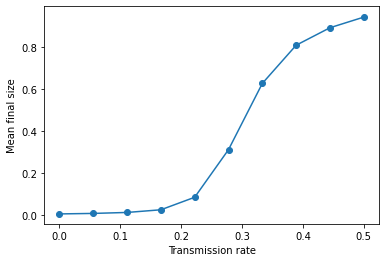

In [2]:
from spreading_CR import SpreadingProcess
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#create a random graph using networkx
seed = 42
N = 1000
k = 10
p = 0.05
G = nx.watts_strogatz_graph(N, k, p, seed=seed)

#propagation parameters
transmission_rate_list = np.linspace(0.0,0.5,10)         
recovery_rate = 1           #rate at which infected nodes become recovered
waning_immunity_rate = 0    #rate at which recovered nodes become susceptible
Inode_list = np.arange(0,5) #Initially infected nodes

#prepare the sampling of the final size
sample_size = 1000
mean_final_size_list = []
std_final_size_list = []

for transmission_rate in transmission_rate_list:
    #initialize the propagation process
    sp = SpreadingProcess(list(G.edges()), transmission_rate, 
                            recovery_rate, waning_immunity_rate)
    
    #get a sample of final size
    final_size_list = []
    for i in range(sample_size):
        #simulate until an absorbing state is reached
        sp.initialize(Inode_list, i)
        sp.evolve(np.inf)
        
        #get data and reset
        final_size_list.append(sp.get_Rnode_number_vector()[-1]/N)
        sp.reset()
    
    #get the statistics
    mean_final_size_list.append(np.mean(final_size_list))
    std_final_size_list.append(np.std(final_size_list))

#get the approximate std on the mean
std_mean_final_size_list = [std/np.sqrt(sample_size) 
                            for std in std_final_size_list]

#draw phase transition
plt.errorbar(transmission_rate_list, mean_final_size_list, 
             yerr = std_mean_final_size_list, fmt = 'o-')
plt.xlabel(r'Transmission rate')
plt.ylabel(r'Mean final size')
plt.show()

# Get the recovered nodes : SIR model

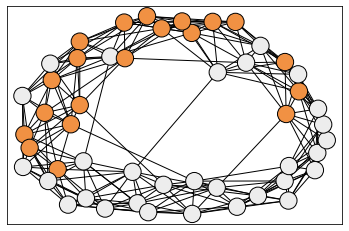

In [3]:
from spreading_CR import SpreadingProcess
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#create a random graph using networkx
seed = 42
N = 50
k = 10
p = 0.05
G = nx.watts_strogatz_graph(N, k, p, seed=seed)

#propagation parameters
transmission_rate = 0.2
recovery_rate = 1
waning_immunity_rate = 0
Inode_list = np.arange(0,2) #Initially infected nodes

#initialize spreading process and evolve until an frozen state is reached
sp = SpreadingProcess(list(G.edges()),transmission_rate, 
                            recovery_rate,waning_immunity_rate)
sp.initialize(Inode_list, seed)
sp.evolve(np.inf)

#get the recovered nodes
recovered_node_set = sp.get_Rnode_set()

#show the recovered nodes in orange
node_color = ["#EDEDED" if n not in recovered_node_set else "#f19143" for n in G]
pos = nx.spectral_layout(G)
pos = nx.spring_layout(G,pos=pos)
nx.draw_networkx_nodes(G,pos=pos,node_color=node_color,edgecolors='k')
nx.draw_networkx_edges(G,pos=pos)
plt.show()

# Initialize the network with recovered (immuned) nodes

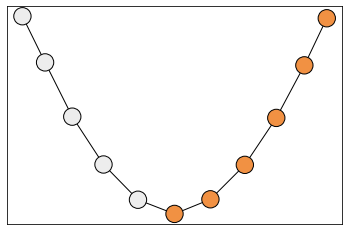

In [4]:
from spreading_CR import SpreadingProcess
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#create a chain graph using networkx
seed = 42
G = nx.Graph()
G.add_edges_from([(i,i+1) for i in range(10)])

#propagation parameters
transmission_rate = 1000.
recovery_rate = 1
waning_immunity_rate = 0
Inode_list = np.arange(0,1) #Initially infected nodes
Rnode_list = [5]

#initialize spreading process and evolve until an frozen state is reached
sp = SpreadingProcess(list(G.edges()),transmission_rate, 
                            recovery_rate,waning_immunity_rate)
sp.initialize(Inode_list, Rnode_list, seed)
sp.evolve(np.inf)

#get the recovered nodes
recovered_node_set = sp.get_Rnode_set()

#show the recovered nodes in orange
node_color = ["#EDEDED" if n not in recovered_node_set else "#f19143" for n in G]
pos = nx.spectral_layout(G)
pos = nx.spring_layout(G,pos=pos)
nx.draw_networkx_nodes(G,pos=pos,node_color=node_color,edgecolors='k')
nx.draw_networkx_edges(G,pos=pos)
plt.show()

# Estimation of $R_0$

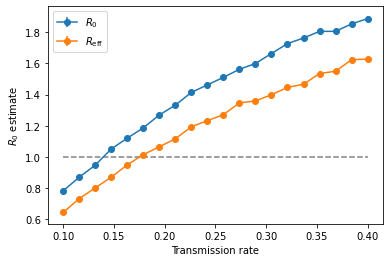

In [5]:
from spreading_CR import SpreadingProcess
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#create a random graph using networkx
seed = 42
N = 1000
k = 10
p = 0.05
G = nx.watts_strogatz_graph(N, k, p, seed=seed)

#propagation parameters
transmission_rate_list = np.linspace(0.1,0.4,20) #important, transmission rate > 0
recovery_rate = 1           #rate at which infected nodes become recovered
waning_immunity_rate = 0    #rate at which recovered nodes become susceptible

#prepare the list for the R0 estimates
sample = 10000 #number of sample for R0
R0_mean_list = []
R0_std_list = []

#do the same for Reff where some nodes are recovered at the beginning
Reff_mean_list = []
Reff_std_list = []
nb_recovered = 200
Rnode_list = np.random.randint(0,N,nb_recovered)

i = 0
for transmission_rate in transmission_rate_list:
    #initialize the propagation process
    sp = SpreadingProcess(list(G.edges()), transmission_rate, 
                            recovery_rate, waning_immunity_rate)
    #R0 estimate
    R0_mean,R0_std = sp.estimate_R0(sample,seed+i)
    R0_mean_list.append(R0_mean)
    R0_std_list.append(R0_std/np.sqrt(sample)) #standard error
    #Reff estimate
    Reff_mean,Reff_std = sp.estimate_R0(sample,seed+i,Rnode_list)
    Reff_mean_list.append(Reff_mean)
    Reff_std_list.append(Reff_std/np.sqrt(sample)) #standard error
    i += 1
    
#draw R0 for different parameters
plt.errorbar(transmission_rate_list, R0_mean_list, 
             yerr = R0_std_list, fmt = 'o-', label='$R_0$')
plt.errorbar(transmission_rate_list, Reff_mean_list, 
             yerr = Reff_std_list, fmt = 'o-',  label='$R_\mathrm{eff}$')
plt.plot([min(transmission_rate_list),max(transmission_rate_list)],
        [1,1], '--', color='grey')
plt.xlabel(r'Transmission rate')
plt.ylabel(r'$R_0$ estimate')
plt.legend()
plt.show()

# Quasi-stationary SIS process

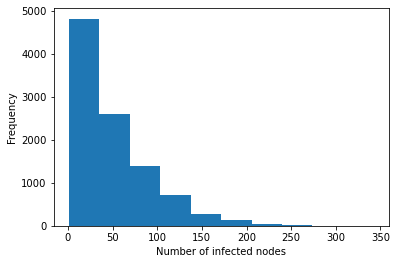

In [6]:
from spreading_CR import QSSpreadingProcess
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

#create a random graph using networkx
seed = 42
N = 10000
p = 10**(-3)
G = nx.fast_gnp_random_graph(N,p, seed = seed)

#propagation parameters
transmission_rate = 0.099
recovery_rate = 1              #rate at which infected nodes become recovered
waning_immunity_rate = np.inf  #rate at which recovered nodes become susceptible
infected_fraction = 0.05       #Initial infected fraction - at random
update_history_rate = 1.
history_vector_size = 100

#initialize the propagation process
sp = QSSpreadingProcess(list(G.edges()), transmission_rate, recovery_rate,
                        waning_immunity_rate, update_history_rate=update_history_rate,
                        history_vector_size=history_vector_size)
sp.initialize_random(infected_fraction, seed)

#let the system thermalize
t = 10000
sp.evolve(t)

#get quasi-stationary distribution
sp.set_update_history_rate(0.1) #no need to update as often
I_sample = []
for sample in range(10000):
    sp.evolve(10.)
    I_sample.append(sp.get_Inode_number())

#draw histogram
plt.hist(I_sample)
plt.xlabel(r'Number of infected nodes')
plt.ylabel(r'Frequency')
plt.show()